# Import

In [10]:
# verify packages are present will present an error if you are missing dependencies
import scipy
import pandas as pd
import numpy as np
import itertools
from random import shuffle
import random
from scipy import stats, optimize
from skbio import DistanceMatrix
from skbio.stats.ordination import PCoA
from __future__ import division
from skbio.stats.distance import pwmantel
from skbio.diversity.beta import pw_distances
from skbio.stats.distance import bioenv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skbio.stats.distance import ANOSIM
import brewer2mpl
from skbio.stats.spatial import procrustes 
import seaborn as sns
import pylab
import matplotlib
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from biom import load_table
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py

Installed autotime.py. To use it, type:
  %load_ext autotime
time: 352 ms


In [11]:
%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.97 ms


# Run the following cell twice


In [12]:
# %load r_pca/r_pca.py
from __future__ import division
import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print 'iteration: {0}, error: {1}'.format(iter, err)

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print 'ymin: {0}, ymax: {1}'.format(ymin, ymax)

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in xrange(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


time: 65.8 ms


### Source:

RPCA:

Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA

# Define functions


In [13]:
def convert_biom_to_pandas(table):
    
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

time: 4.55 ms


### Source:

Biom to pandas dataframe code:

Jamie Morton, gneiss, (2016), GitHub repository, https://github.com/biocore/gneiss

In [14]:
def scatter_3d(ord_results, df, column, color_map, axis1=0,axis2=1, axis3=2):

    coord_matrix = ord_results.site.T
    ids = ord_results.site_ids
    colors = [color_map[df[column][id_]] for id_ in ord_results.site_ids]
    color_names = list(color_map.keys())
    color_names.sort()
    colosr_names = list(color_map.values())
    fig = plt.figure(2, figsize=(10, 8))
    list_list= list(set(df['Gastrointestinal Disorder'].tolist()))
    leg_col = list(set(colors))

    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig, elev=-150, azim=110)
    xs = coord_matrix[axis1]
    ys = coord_matrix[axis2]
    zs = coord_matrix[axis3]
    plot = ax.scatter(xs, ys, zs, c=colors,s=150)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_axis_bgcolor('white')
    ax.set_xlabel("1st eigenvector", fontsize=30)
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector", fontsize=30)
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector", fontsize=30)
    ax.w_zaxis.set_ticklabels([])
    
    #legend
    scatter_proxy=[]
    q=0
    k, v = color_map.keys(), color_map.values()
    for q in range(len(k)):
        scatter_proxy.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=v[q], marker = 'o'))
    return fig

time: 30.9 ms




# Import Metadata and build classifiers from columns of the data 

In [15]:
df= pd.read_table('data/crohns_meta_data.txt', index_col=0)
label_save=[]


#children only 
df = df[df['antibiotics'] != 'True'] # no antibiotics we need to reduce the count for processing 
df = df[df['Gastrointestinal Disorder'] != 'UC'] # no UC we need to reduce the count for processing 
df = df[df['Gastrointestinal Disorder'] != 'IC'] # no IC we need to reduce the count for processing 

#save names
map_names= pd.read_table('data/crohns_meta_data.txt', index_col=0)
map_names = map_names[map_names['antibiotics'] != 'True'] # no antibiotics we need to reduce the count for processing 
map_names = map_names[map_names['Gastrointestinal Disorder'] != 'UC'] # no antibiotics we need to reduce the count for processing 
map_names = map_names[map_names['Gastrointestinal Disorder'] != 'IC'] # no antibiotics we need to reduce the count for processing 


# set sting based netadata to numerical classifiers
classifier_names = df.columns.values.tolist()
imdex_list = df.index.values.tolist()
for nm in classifier_names:

    if df[nm].dtype == np.dtype(object) or df[nm].dtype == np.dtype(bool) :
        
        # get set of strings in column

        dfList = df[nm].tolist()
        dflistset = set(dfList)
        dfsetdict={}
        q=0
        
        # assign each string in set a integer classifier

        for tmpclassify in dflistset:
            dfsetdict[tmpclassify]=q
            q+=1
        label_save.append(dfsetdict)
        # re name data according assigned values

       
        for in_tmp in imdex_list:
            tmp_rename=df[nm][str(in_tmp)]
            for key, value in dfsetdict.iteritems():
                if tmp_rename == key:
                    df.set_value(str(in_tmp), nm, value)
                    
                    
map_names = map_names.drop('antibiotics', 1)
map_names = map_names.drop('sample_type', 1)
map_names = map_names.drop('Ileal_Invovlement', 1)
df = df.drop('antibiotics', 1)
df = df.drop('sample_type', 1)
df = df.drop('Ileal_Invovlement', 1)
samplenames = df.index.values.tolist()
samplenames = map(str, samplenames)

time: 109 ms


# Import the Crohns study OTU table

In [16]:
table = load_table('data/crohns.biom')
otu, taxonomy = convert_biom_to_pandas(table)

otu=otu.T
#add taxa names

taxonomy['fg'] = taxonomy['kingdom'].str.cat(taxonomy['family'])
result = pd.concat([otu, taxonomy], axis=1, join='inner')
otu2 = result.set_index('fg')
otu2 = otu2.drop(['kingdom','phylum','class','order','family','genus','species'], 1)
otu=otu2

# reoder according to classifier Y
otu=otu.T
otu=otu.reindex(samplenames)
otu=otu.T
otu_check=otu

# only keep OTUs with sum accross columns of 100

otulist = otu.columns.values.tolist()
for nm in otulist:
    if otu[nm].sum() < 1:
        otu.drop(nm, axis=1, inplace=True)
        
        
df = df.fillna(0)
otu =otu.fillna(0)

# save data and names from data frame

index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = map(str, ids)

#check mapping again 

df=df.reindex(ids)

time: 923 ms


# View some the data

In [17]:
print "\nMetadata (classifiers are columns, sample names in rows):"
display(map_names.head())
print "\nOTU table (sample names are columns, OTU names in rows):"
HTML(otu.head().to_html())


Metadata (classifiers are columns, sample names in rows):


,Age,Biopsy location,Gastrointestinal Disorder,Sex
sample_name,,,,
1939.100001,19.0,stool,CD,male
1939.100003,26.0,stool,CD,male
1939.100015,57.0,stool,CD,female
1939.100046,61.0,stool,CD,male
1939.100052,23.0,stool,CD,male



OTU table (sample names are columns, OTU names in rows):


,1939.100001,1939.100003,1939.100015,1939.100046,1939.100052,1939.100058,1939.100065,1939.100072,1939.100074,1939.100075,1939.100077,1939.100083,1939.100085,1939.100087,1939.100088,1939.100091,1939.100092,1939.100101,1939.100102,1939.100105,1939.100107,1939.100115,1939.100158,1939.100161,1939.100163,1939.100176,1939.100178,1939.100187,1939.100191,1939.100192,1939.100195,1939.100197,1939.100198,1939.100203,1939.100205,1939.100207,1939.100209,1939.100212,1939.100217,1939.100222,1939.100225,1939.100226,1939.100234,1939.120153,1939.120155,1939.120156,1939.120157,1939.121154,1939.121181,1939.121182,1939.121183,1939.121185,1939.121187,1939.121191,1939.121194,1939.121195,1939.121196,1939.121197,1939.121199,1939.121201,1939.121213,1939.121216,1939.121217,1939.121218,1939.121219,1939.121279,1939.121281,1939.121282,1939.121283,1939.121307,1939.121308,1939.121311,1939.121312,1939.121313,1939.121314,1939.121385,1939.121386,1939.121387,1939.121388,1939.121402,1939.121404,1939.121405,1939.121421,1939.121422,1939.121423,1939.121444,1939.121445,1939.121446,1939.121449,1939.121451,1939.121452,1939.121457,1939.121461,1939.121464,1939.121466,1939.121467,1939.121468,1939.121469,1939.121471,1939.121473,1939.121474,1939.121475,1939.121476,1939.121477,1939.121479,1939.121492,1939.121493,1939.121495,1939.121496,1939.121497,1939.121499,1939.121502,1939.121503,1939.121969,1939.121971,1939.121982,1939.122004.a,1939.122004.b,1939.122007,1939.122010.a,1939.122010.b,1939.122011,1939.122032,1939.122038,1939.122039.a,1939.122039.b,1939.122049,1939.122057.a,1939.122057.b,1939.122058,1939.122059,1939.122062,1939.122072,1939.122074,1939.122075,1939.122076,1939.122077,1939.122078,1939.122079,1939.122096.a,1939.122096.b,1939.122097,1939.122098.a,1939.122098.b,1939.122099.a,1939.122099.b,1939.122100.a,1939.122100.b,1939.122101,1939.122113.a,1939.122113.b,1939.122115.a,1939.122115.b,1939.122116.a,1939.122116.b,1939.122117.a,1939.122117.b,1939.122119.a,1939.122119.b,1939.MGH100079,1939.MGH100695.a,1939.MGH100695.b,1939.MGH100698,1939.MGH100748,1939.MGH100826,1939.MGH100896.a,1939.MGH100896.b,1939.MGH101010,1939.MGH101089,1939.MGH101446,1939.MGH101468,1939.MGH101666,1939.MGH101725,1939.MGH101748,1939.MGH101763,1939.MGH102203,1939.MGH102228,1939.MGH102271,1939.MGH102386,1939.MGH102504,1939.MGH102701,1939.MGH102719,1939.MGH102797,1939.MGH102894,1939.MGH102965,1939.MGH103108,1939.MGH103128,1939.MGH103539,1939.MGH103547,1939.MGH103660,1939.MGH103728,1939.MGH103785,1939.MGH103891,1939.MGH103912,1939.MGH104119,1939.MGH104421,1939.MGH104519,1939.MGH104671.a,1939.MGH104671.b,1939.MGH104690,1939.MGH104824.a,1939.MGH104824.b,1939.MGH104884,1939.MGH105057,1939.MGH105192,1939.MGH105234,1939.MGH105239,1939.MGH105361,1939.MGH105450,1939.MGH105553,1939.MGH105618,1939.MGH105658,1939.MGH105693,1939.MGH105700,1939.MGH106271.a,1939.MGH106271.b,1939.MGH106288,1939.MGH106399,1939.MGH109339,1939.MGH109531,1939.MGH109614,1939.MGH109682,1939.MGH109812,1939.MGH110455,1939.MGH113059,1939.MGH113364,1939.MGH113527,1939.MGH129951,1939.SKBTI.0097,1939.SKBTI.0099,1939.SKBTI.0102.a,1939.SKBTI.0102.b,1939.SKBTI.0103,1939.SKBTI.0104,1939.SKBTI.0107.a,1939.SKBTI.0107.b,1939.SKBTI.0108,1939.SKBTI.0110,1939.SKBTI.0112.a,1939.SKBTI.0112.b,1939.SKBTI.0113,1939.SKBTI.0114,1939.SKBTI.0116,1939.SKBTI.0118,1939.SKBTI.0119,1939.SKBTI.0120,1939.SKBTI.0121,1939.SKBTI.0122.a,1939.SKBTI.0122.b,1939.SKBTI.0124,1939.SKBTI.0125,1939.SKBTI.0126,1939.SKBTI.0127,1939.SKBTI.0128,1939.SKBTI.0129,1939.SKBTI.0132,1939.SKBTI.0134.a,1939.SKBTI.0134.b,1939.SKBTI.0135,1939.SKBTI.0137,1939.SKBTI.0139,1939.SKBTI.0141.a,1939.SKBTI.0141.b,1939.SKBTI.0142,1939.SKBTI.0143.a,1939.SKBTI.0143.b,1939.SKBTI.0144,1939.SKBTI.0146,1939.SKBTI.0147,1939.SKBTI.0149,1939.SKBTI.0150.a,1939.SKBTI.0150.b,1939.SKBTI.0151,1939.SKBTI.0152,1939.SKBTI.0155,1939.SKBTI.0156,1939.SKBTI.0158,1939.SKBTI.0159,1939.SKBTI.0160,1939.SKBTI.0161,1939.SKBTI.0163,1939.SKBTI.0164,1939.SKBTI.0165,1939.SKBTI.0167,1939.SKBTI.0168,1939.SKBTI.0169,1939.SKBTI.0170,1939.SKB

time: 521 ms


# Decompose the data with 43 iterations
#### (pre-determined number based on over and underfitting)

## To view the idea behind this method see the notebook Decomposition_Exsplained

### At a high level we will solve the problem below convexly

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix

In [18]:
rpcadata=np.array(data)
rpca = R_pca(rpcadata)
L, S = rpca.fit(max_iter=48, iter_print=100)
low_rank_matrix = L
sparse_matrix = S

iteration: 1, error: 19483381151.5
time: 1min 4s


#### Assume

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix


Not only can this problem be solved, it can be solved by tractable convex optimization. 


Let $ ||M||_{*} := \sum_{i}σ_{i}(M)$ denote the nuclear norm of the matrix M, 

i.e. the sum of the singular values of M

Let $ ||M||_{1} := \sum_{ij}||M||_{ij}$ denote the 1-norm of M seen as a long vector in R n1×n2

Then it can be shown that the Principal Component Pursuit (PCP) estimate solving


Minimize $ ||L||_{*} + λ||S||_{1}$

Subject to $L + S = M$

It can be shown that this exactly recovers the low-rank $L_{0}$ and the sparse $S_{0}$. Theoretically, this is guaranteed to work even if the rank of $L_{0}$ grows almost linearly in the dimension of the matrix, and the errors in $S_{0}$ are up to a constant fraction of all entries.

#### source


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA


#### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

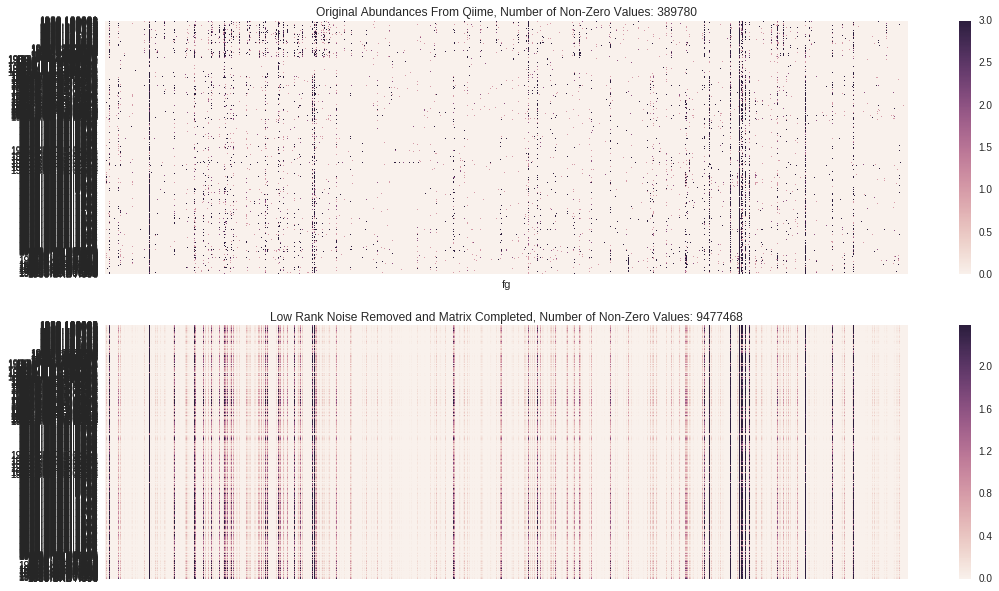

time: 39.5 s


In [19]:
save_lowrankdf = pd.DataFrame(low_rank_matrix,index=index, columns=ids)
save_sparsedf = pd.DataFrame(sparse_matrix, columns=ids)
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(18, 10))
sns.heatmap(otu.T, robust=True,xticklabels=False, ax=ax1,vmin=0)
sns.heatmap(save_lowrankdf.T, robust=True,xticklabels=False, ax=ax2,vmin=0)
ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=360)
ax2.set_yticklabels(ax2.yaxis.get_majorticklabels(), rotation=360)
ax1.set_title('Original Abundances From Qiime, Number of Non-Zero Values: %i'%np.count_nonzero(otu))
ax2.set_title('Low Rank Noise Removed and Matrix Completed, Number of Non-Zero Values: %i'%np.count_nonzero(low_rank_matrix))
plt.show()

# The high level idea is now that we have obtained our underlying compositional signal from the data we can now determine which classifiers are most relevent based on our microbial composition between samples. We can also determine the bacteria that explain the variance between theese groups and then mapp theese back to the origonal data.

# This is done through machine learning

# Supervised 

<img src="etc/supervised_learning.jpg">

# First we will use supervised learning

# Plot
### Coefficient of determination R^2 of the prediction.
The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred)2).sum() and v is the residual sum of squares ((y_true - y_true.mean())2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

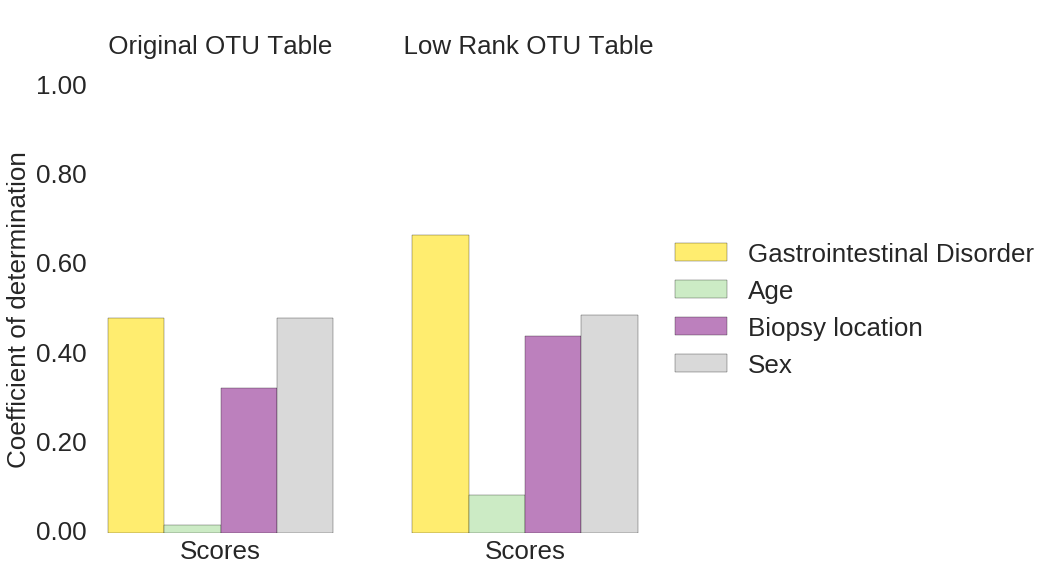

time: 7.62 s


In [20]:

########### Model, Cross-Validate and plot Recall Scores for origonal and low-rank data  #############


#low rank

classifiers_meta=df.columns.values.tolist()
X =low_rank_matrix.T
sv={}

for metatmp in classifiers_meta[:]:

    Y=df[metatmp].tolist()
    Y = map(int, Y)

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=42)
    pca = PCA(n_components=3)
    pca.fit(X_train)
    X_t_train = pca.transform(X_train)
    X_t_test = pca.transform(X_test)
    clf = svm.LinearSVC(random_state=29)
    clf.fit(X_t_train, y_train)
    sv[metatmp] = clf.score(X_t_test, y_test)

    
########### Model, Cross-Validate and plot Recall Scores for origonal and origonal data  #############


X =data.T
svorg={}

for metatmp in classifiers_meta[:]:

    Y=df[metatmp].tolist()
    Y = map(int, Y)

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=42)
    pca = PCA(n_components=3)
    pca.fit(X_train)
    X_t_train = pca.transform(X_train)
    X_t_test = pca.transform(X_test)
    clf = svm.LinearSVC(random_state=29)
    clf.fit(X_t_train, y_train)
    svorg[metatmp] = clf.score(X_t_test, y_test)
    

############ Convert dict to dataframe and choose colors ##################################

    
scores = pd.DataFrame(sv.items())
scores=scores.set_index(scores[0])
scores = scores.drop([0], 1)
scores.columns = ['Scores']
bmap = brewer2mpl.get_map('Set3','qualitative',12,reverse=True)
colors = bmap.mpl_colors
scores2 = pd.DataFrame(svorg.items())
scores2=scores2.set_index(scores2[0])
scores2 = scores2.drop([0], 1)
scores2.columns = ['Scores']

################## plot the scores #######################

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(25, 10))
#fig.suptitle('Coefficient of determination for Each Classifier \n\n\n\n', fontsize=28, y=1.08)
scores2.T.plot(kind='bar',stacked=False,color=colors,legend=False, ylim=(0,1),figsize=(10, 8), width=4.0,fontsize=26,ax=ax1)
scores.T.plot(kind='bar', stacked=False,color=colors,legend=False, ylim=(0,1),figsize=(10, 8), width=4.0,fontsize=26,ax=ax2)
ax2.set_yticklabels([])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':26})
ax2.set_title('\n  Low Rank OTU Table \n',fontsize= 26) # title of plot\
ax2.set_axis_bgcolor('white')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}'.format(x) for x in vals])
ax1.set_ylabel("Coefficient of determination",{'size':'26'})
ax1.set_title('\n Original OTU Table \n',fontsize= 26) # title of plot
ax1.set_axis_bgcolor('white')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

## The results of SVC in both the low-rank and original data revealed gastrointestinal disease (GD) as the best classifier. This demonstrates that when the original data already contains trends the low-rank component also contains those trends boosted. Furthermore the origonal data gives the spurious result of sex which was reduced in the low-rank matrix.

# Classically PCA cannot be used to determine clustering of data in 16S because PCA is skewed by outliers and can only deal with small I.I.D. Gaussian nosie

<img src="etc/pca_vs_outlier.png">


# Now that we have recovered the low rank data lets view the PCA and PCoA clustering by the classifier we revealed through unsuperised learning Gastro Disease!

### Unsupervised Learning  (no labels)

<img src="etc/leanring_model.png">

### the way we will cluster - agglomerative 

<img src="etc/clustering.png">

### Structured means we have some prior knowledge, our prior on the clustering is k-nearest neighbors

<img src="etc/effect-of-k.png">



# Origonal Matrix

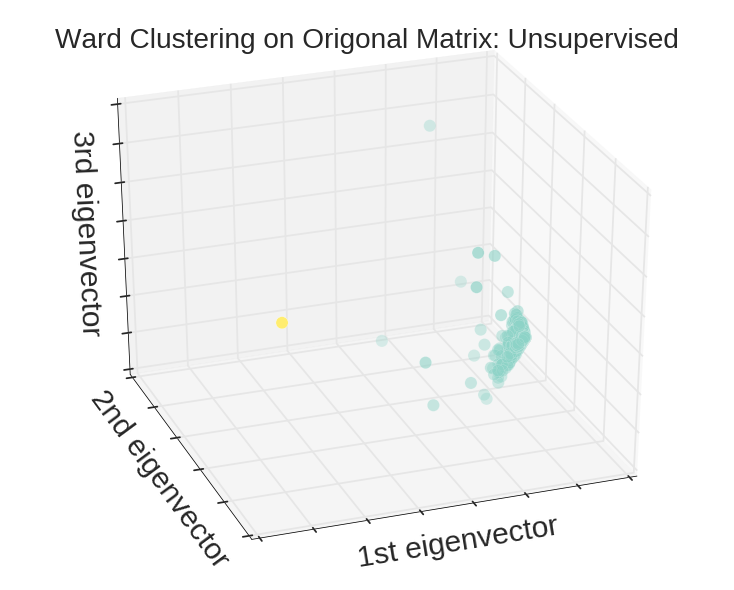

Completeness Score: 0.001734
time: 5.53 s


In [25]:
########### prigonal data agglomerative clustering #################
Y_true = df['Gastrointestinal Disorder'].tolist()
X2=data.T
ward2 = AgglomerativeClustering(n_clusters=2,linkage='ward').fit(X2)
Y_pred = ward2.labels_
score = completeness_score(Y_pred,Y_true)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced2 = PCA(n_components=3).fit_transform(X2)
ax.scatter(X_reduced2[:, 0], X_reduced2[:, 1], X_reduced2[:, 2], c=Y_pred,cmap=plt.cm.Set3,s=150,color='white')
ax.set_title("Ward Clustering on Origonal Matrix: Unsupervised",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.show()
print 'Completeness Score: %f'%score

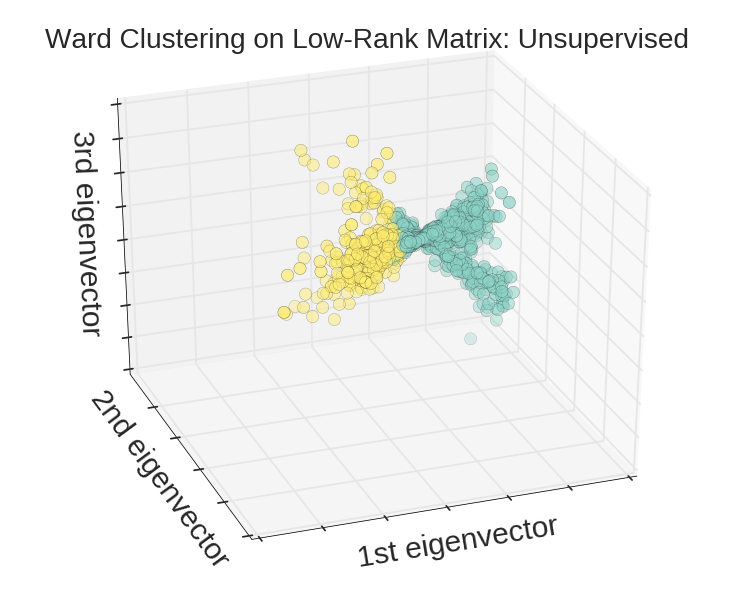

Completeness Score: 0.025165
time: 5.51 s


In [26]:
########### low rank agglomerative clustering #################
X =low_rank_matrix.T
Y_true = df['Gastrointestinal Disorder'].tolist()
ward = AgglomerativeClustering(n_clusters=2,linkage='ward').fit(X)
Y_pred = ward.labels_
score = completeness_score(Y_pred,Y_true)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred,cmap=plt.cm.Set3,s=150)
ax.set_title("Ward Clustering on Low-Rank Matrix: Unsupervised",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.show()
print 'Completeness Score: %f'%score

# Now we can compare this to the labeled PCA using GD as a label

##### Origonal Matrix

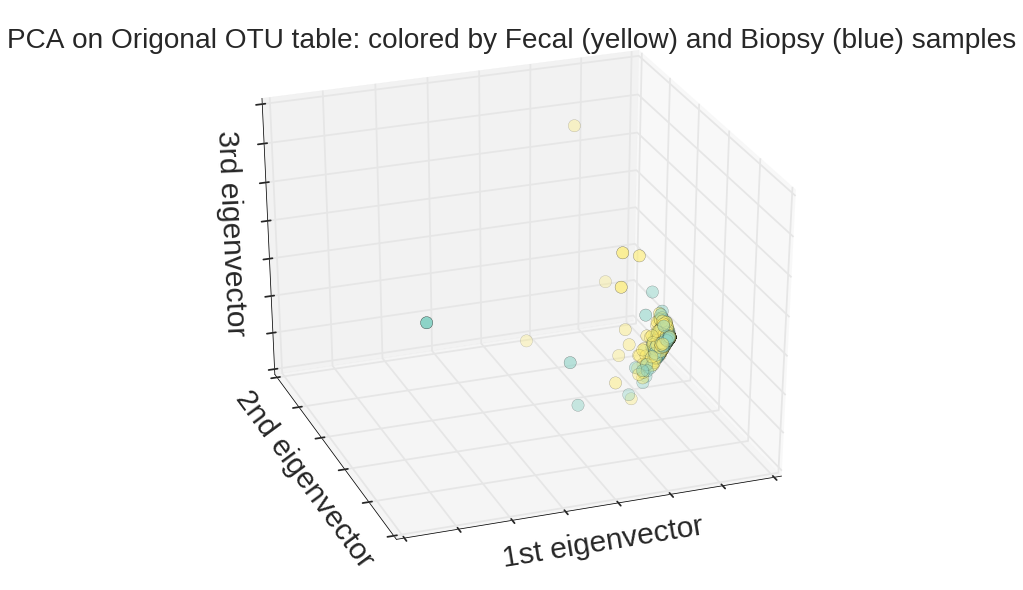

Silhouette Coefficient: 0.025449
time: 1.67 s


In [27]:
Y=df['Gastrointestinal Disorder'].tolist()
Y = map(int, Y)
X =data.T
Y_true = np.asarray(df['Gastrointestinal Disorder'].tolist())
silhouette_avg = silhouette_score(X, Y_true)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.Set3,s=150)
ax.set_title("PCA on Origonal OTU table: colored by Fecal (yellow) and Biopsy (blue) samples",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.show()
print 'Silhouette Coefficient: %f'%silhouette_avg 

##### Low Rank Matrix

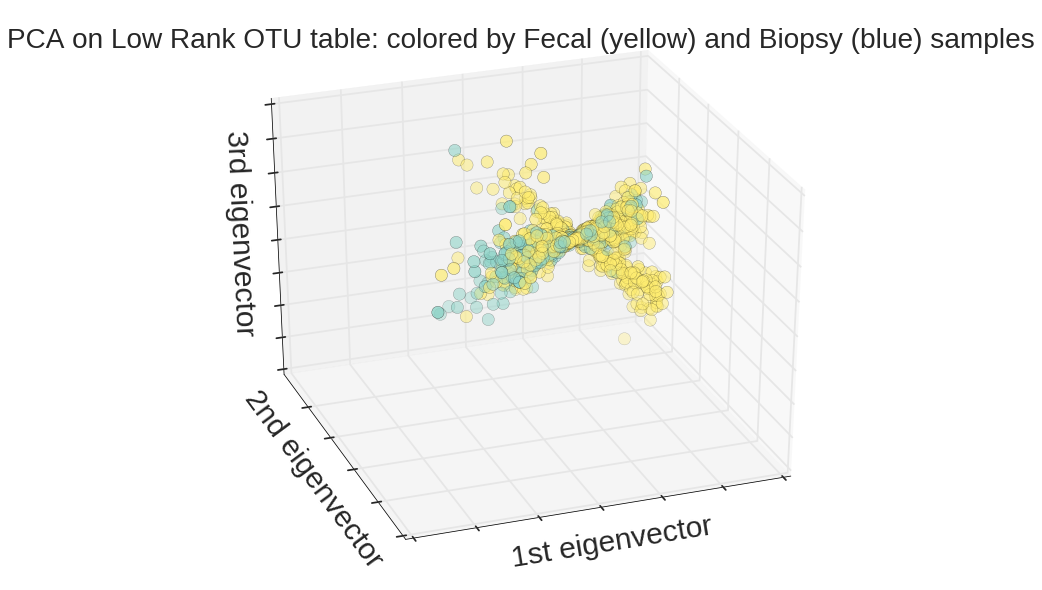

Silhouette Coefficient: 0.072657
time: 1.32 s


In [28]:
%matplotlib inline
Y=df['Gastrointestinal Disorder'].tolist()
Y = map(int, Y)
X = low_rank_matrix.T
Y_true = np.asarray(df['Gastrointestinal Disorder'].tolist())
silhouette_avg = silhouette_score(X, Y_true)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.Set3,s=150)
ax.set_title("PCA on Low Rank OTU table: colored by Fecal (yellow) and Biopsy (blue) samples",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.show()
print 'Silhouette Coefficient: %f'%silhouette_avg 

# Recovering information about features from PCA eigenvectors  

### The priniple components are a linear combination of origonal features in N dimentional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are wieghts and $X_{N}$ is the origonal variables

#### Therefore the coefficients are the transfrom of an idenity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 


/home/cameron/anaconda2/envs/RPCA_env/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


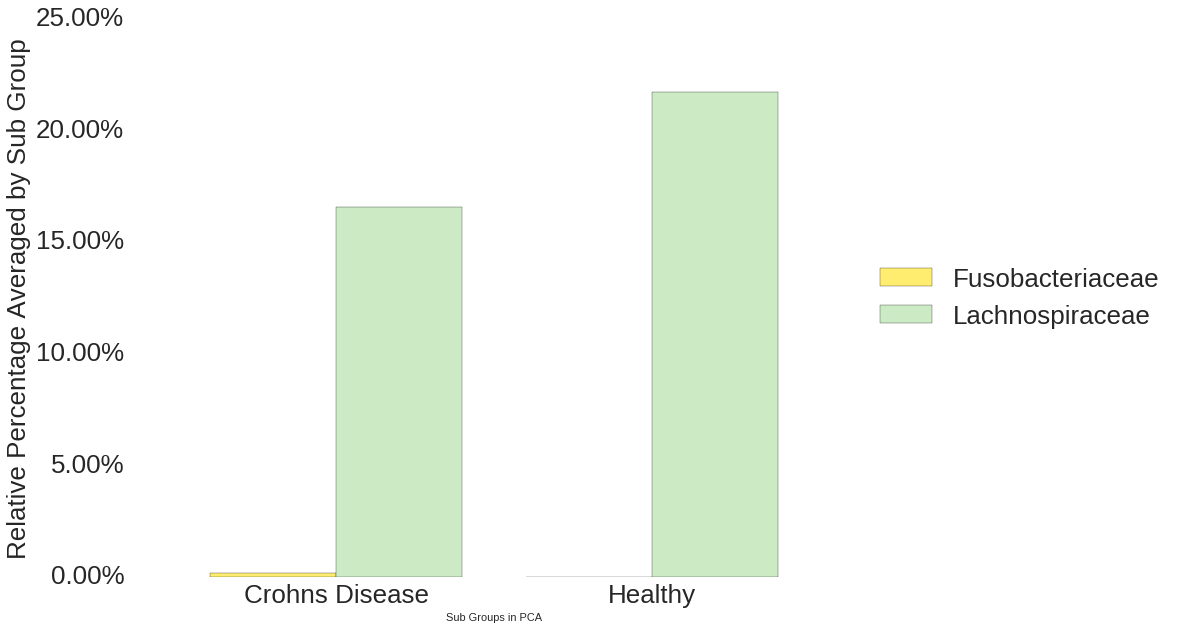

time: 1.29 s


In [68]:
# PCA
%matplotlib inline
pca = PCA(n_components=3)
pca.fit_transform(save_lowrankdf.T)

# Dump components relations with features:

df2 = pd.DataFrame(pca.components_,columns=save_lowrankdf.T.columns,index = ['PC-1','PC-2','PC-3']).T
df2.abs()
df2.sort(['PC-1'], ascending = [True], inplace = True)
bact_list = df2.index.values.tolist()
check='start'

bactandotu=otu
for n in bactandotu.columns.values.tolist():
    if n != 'bact_id':
        wtemp = ((100/(bactandotu["%s"%n].sum()))*100)
        bactandotu['%s'%n] = bactandotu['%s'%n] *wtemp



for bact in bact_list[:2]:
    if check=='start':
        def3=bactandotu.T[bact]
        def3.sum(axis=1)
        def2=def3.T[-1:]
        def2=def2.T
        def2['Sub Groups in PCA'] = map_names['Gastrointestinal Disorder']
        def2=def2.groupby('Sub Groups in PCA', as_index=False).mean()
        def2 = def2.set_index('Sub Groups in PCA')
        check='not-start'
    else:
        def3tmp=bactandotu.T[bact]
        def3tmp.sum(axis=1)
        def2tmp=def3tmp.T[-1:]
        def2tmp=def2tmp.T
        def2tmp['Sub Groups in PCA'] = map_names['Gastrointestinal Disorder']
        def2tmp=def2tmp.groupby('Sub Groups in PCA', as_index=False).mean()
        def2tmp = def2tmp.set_index('Sub Groups in PCA')
        def2 = pd.concat([def2, def2tmp], axis=1, join='inner')
    
   
        
def2 = def2.T
def2.rename(columns={'CD': 'Crohns Disease', 'no': 'Healthy'}, inplace=True)
def2 = def2.T
def2.rename(columns={'k__Bacteriaf__Lachnospiraceae': 'Lachnospiraceae', 'k__Bacteriaf__Fusobacteriaceae': 'Fusobacteriaceae'}, inplace=True)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(36, 10))
bmap = brewer2mpl.get_map('Set3','qualitative',12,reverse=True)
colors = bmap.mpl_colors
def2.plot(kind='bar', stacked=False,color=colors,legend=True, width=.80, figsize=(13, 10),fontsize=26,ax=ax1)
vals = ax1.get_yticks()
ax1.set_axis_bgcolor('white')
ax1.set_yticklabels(['{:3.2f}%'.format(x) for x in vals])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':26})
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.tick_params(axis='y', labelsize=26)
ax1.set_ylabel("Relative Percentage Averaged by Sub Group",{'size':'26'})
#plt.savefig('/home/cameron/Desktop/final_fig/crohns/extract_pca.png',transparent=True, dpi=300)

plt.show()

## This makes biological sense! The bacteria causing the most variance between CD and healthy patients belong to the family Lachnospiraceae (Fig 2E). A result concluded by others to be increased in healthy patients versus CD patients (Frank et al., 2007).

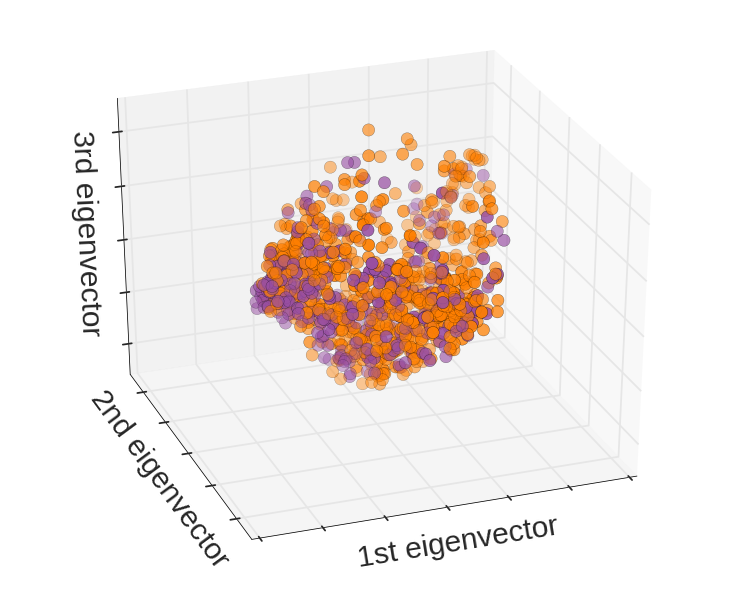

anosim results:
Method name  Sample size  Number of groups       R statistic  p-value  Number of permutations
     ANOSIM         1052                 2  -0.0545250987968    1.000                     999

time: 11.9 s


In [52]:

############### Calculate PCoA ##########################################

df= pd.read_table('data/crohns_meta_data.txt', index_col=0)


#children only 
df = df[df['antibiotics'] != 'True'] # no antibiotics we need to reduce the count for processing 
df = df[df['Gastrointestinal Disorder'] != 'UC'] 
df = df[df['Gastrointestinal Disorder'] != 'IC'] 
df = df.drop('antibiotics', 1)
df = df.drop('sample_type', 1)
df = df.drop('Ileal_Invovlement', 1)

df2=df

df.index = df.index.map(str)
all_dm = pw_distances(rpcadata.T, ids, "braycurtis")
all_dm_pc = PCoA(all_dm).scores()
df3= df2.T
samplenames = df3.ix[2,:].tolist()
samplenames = map(str, samplenames)
dflist = list(df2.columns.values)
remove = 0, 1, 2, 3
labels = [i for j, i in enumerate(dflist) if j not in remove]
df3=df2.T
Descript = df3.ix[2,:].tolist()
deslist=[]
for hcek in Descript:
    if hcek not in deslist:
        deslist.append(hcek)
    if hcek in deslist:
        continue

        
bmap1 = brewer2mpl.get_map('Set1','qualitative',5,reverse=True)
bmap2 = brewer2mpl.get_map('Dark2','qualitative',8,reverse=True)
colors1 = bmap1.mpl_colors
colors2 = bmap2.mpl_colors
colors=colors1+colors2
dictionary_legnd = dict(zip(deslist, colors))

fig1 = scatter_3d(all_dm_pc, df2, 'Gastrointestinal Disorder', dictionary_legnd)

plt.savefig('/home/cameron/fix_typo/pcoa.png',transparent=True, dpi=300)

plt.show()
anosim = ANOSIM(all_dm, df, column='Gastrointestinal Disorder')
results = anosim(999)
print "anosim results:"
print results

# As you can see there is some gradient here but using PCoA this gradient cannot be explained biologically through multivariate wieghts like PCA

In [53]:
plt.close('all')

time: 774 µs
